روش های مورد نظر را انتخاب کنید (lax, lax_wendroff, leap_frog, mac_cormack, upwind یا all): all


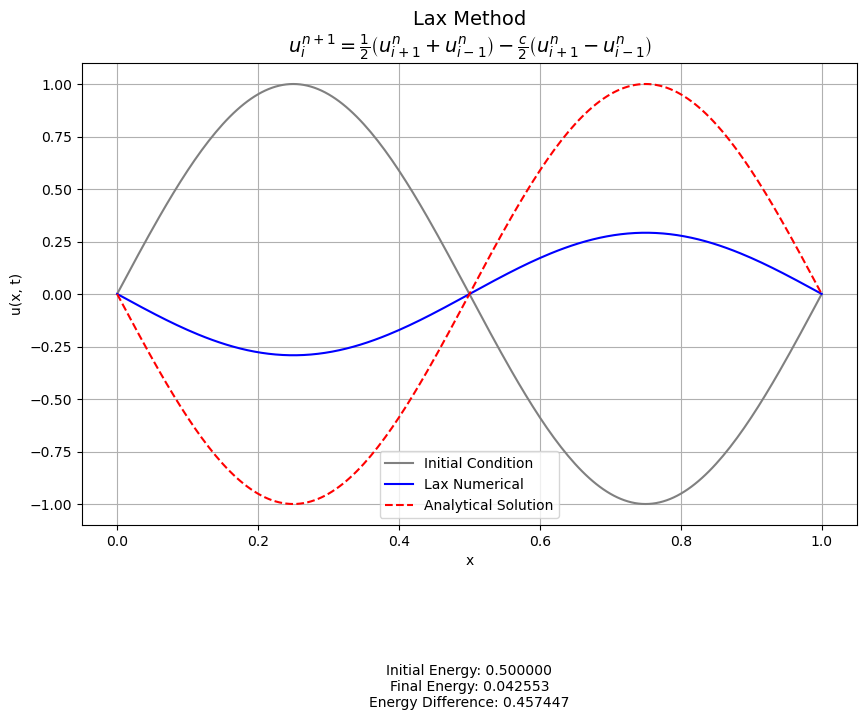

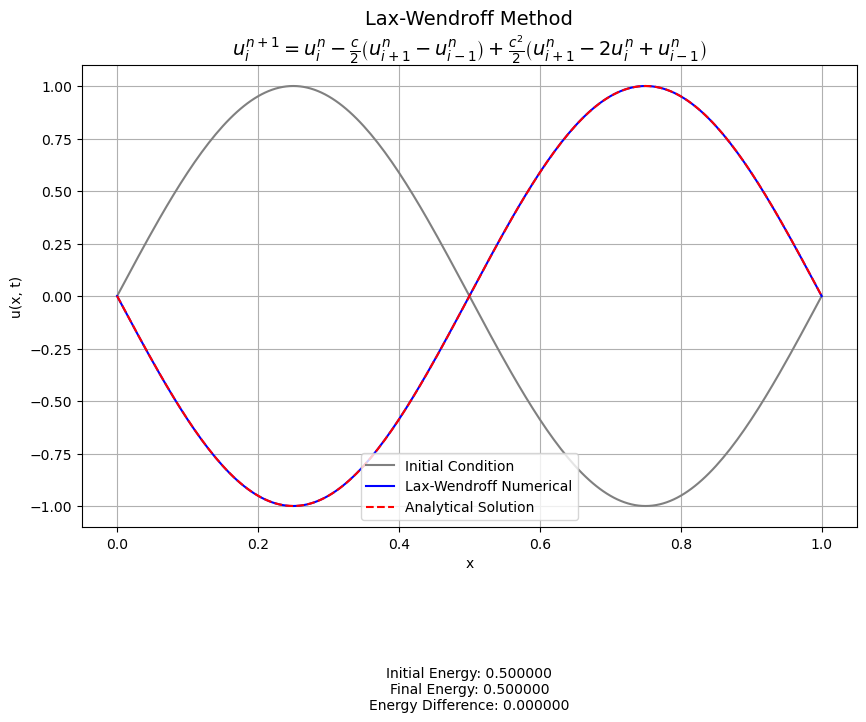

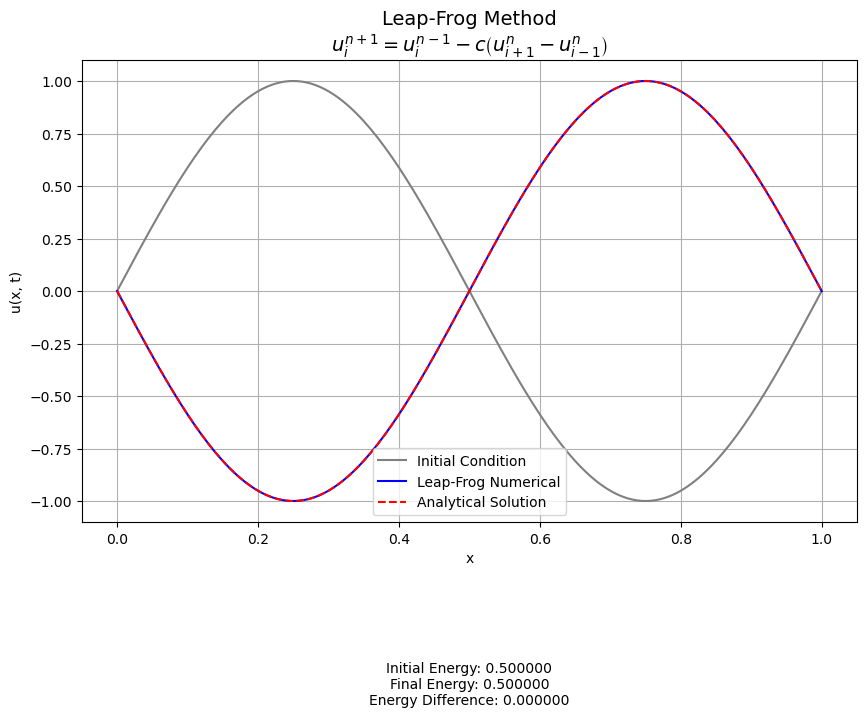

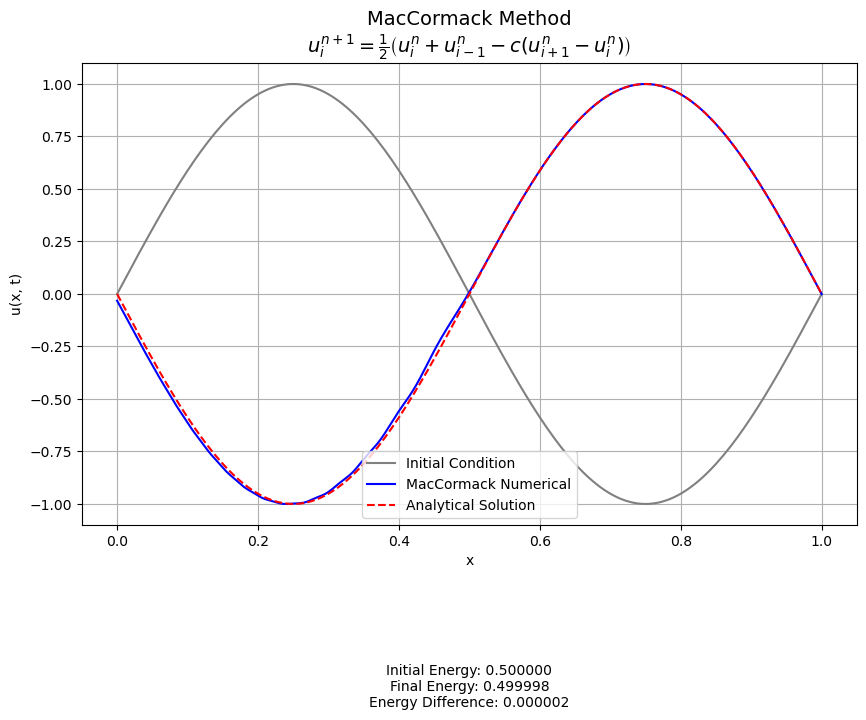

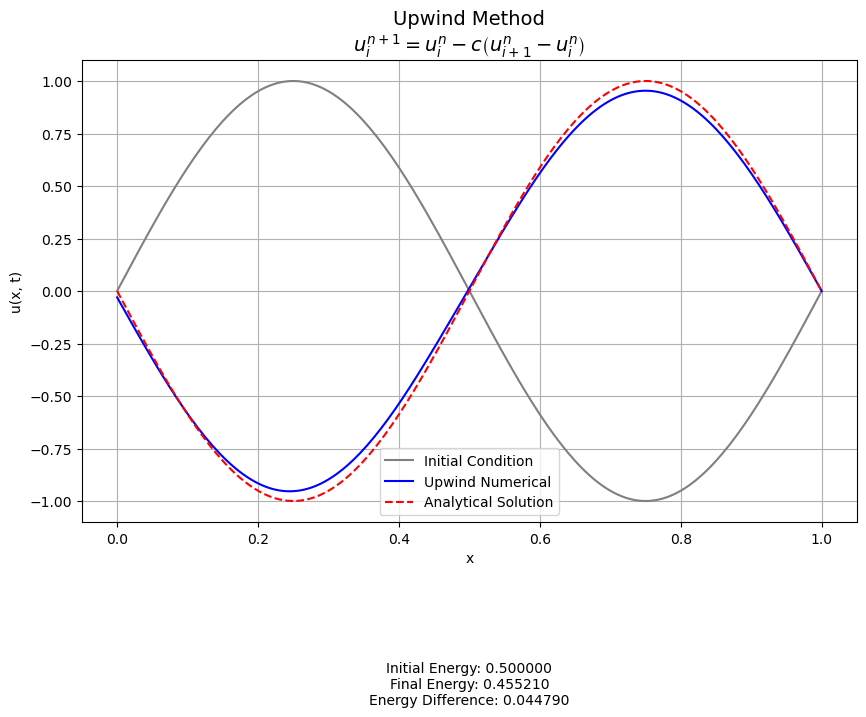

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve


a = 0.2  
L = 1.0 
T = 2.5  
N = 201  
dx = L / (N - 1)  
dt = 0.001  
Nt = int(T / dt) 
c = a * dt / dx 

if c > 1:
    raise ValueError("شرط CFL برقرار نیست: مقدار c باید <= 1 باشد.")




def lax_wendroff(u, c, N, Nt):
    for n in range(Nt):
        for i in range(1, N - 1):
            u[i, n + 1] = (
                u[i, n]
                - 0.5 * c * (u[i + 1, n] - u[i - 1, n])
                + 0.5 * c**2 * (u[i + 1, n] - 2 * u[i, n] + u[i - 1, n])
            )
        u[0, n + 1] = (
            u[0, n]
            - 0.5 * c * (u[1, n] - u[-2, n])
            + 0.5 * c**2 * (u[1, n] - 2 * u[0, n] + u[-2, n])
        )
        u[-1, n + 1] = u[0, n + 1]
    return u


def leap_frog(u, c, N, Nt):
    for i in range(1, N - 1):
        u[i, 1] = u[i, 0] - c * (u[i, 0] - u[i - 1, 0])
    u[0, 1] = u[0, 0] - c * (u[0, 0] - u[-2, 0])
    u[-1, 1] = u[0, 1]

    for n in range(1, Nt):
        for i in range(1, N - 1):
            u[i, n + 1] = u[i, n - 1] - c * (u[i + 1, n] - u[i - 1, n])
        u[0, n + 1] = u[0, n - 1] - c * (u[1, n] - u[-2, n])
        u[-1, n + 1] = u[0, n + 1]
    return u


def mac_cormack(u, c, N, Nt):
    for n in range(Nt):
        u_pred = np.zeros_like(u[:, n])
        u_pred[:-1] = u[:-1, n] - c * (u[1:, n] - u[:-1, n])
        u_pred[-1] = u[-1, n] - c * (u[0, n] - u[-1, n])
        u[1:, n + 1] = 0.5 * (u[1:, n] + u_pred[1:] - c * (u_pred[1:] - u_pred[:-1]))
        u[0, n + 1] = 0.5 * (u[0, n] + u_pred[0] - c * (u_pred[0] - u_pred[-1]))
    return u


def lax(u, c, N, Nt):
    for n in range(Nt):
        u[1:-1, n + 1] = 0.5 * (u[2:, n] + u[:-2, n]) - 0.5 * c * (u[2:, n] - u[:-2, n])
        u[0, n + 1] = 0.5 * (u[1, n] + u[-2, n]) - 0.5 * c * (u[1, n] - u[-2, n])
        u[-1, n + 1] = u[0, n + 1]
    return u




def upwind(u, c, N, Nt):
    A = np.eye(N)
    for i in range(1, N):
        A[i, i] = 1 - c
        A[i, i - 1] = c
    A[0, -1] = c
    A[0, 0] = 1 - c

    for n in range(Nt):
        u[:, n + 1] = A @ u[:, n]
    return u


def analytical_solution(x, a, t):
   
    return np.sin(2 * np.pi * (x - a * t))


def compute_energy(u, dx):
    
    return np.sum(u**2) * dx


methods = input(
    "روش های مورد نظر را انتخاب کنید (lax, lax_wendroff, leap_frog, mac_cormack, upwind یا all): "
).strip().split(",")

x = np.linspace(0, L, N)
results = {}


latex_formulas = {
    "Lax": r"$u_i^{n+1} = \frac{1}{2} \left( u_{i+1}^n + u_{i-1}^n \right) - \frac{c}{2} \left( u_{i+1}^n - u_{i-1}^n \right)$",
    "Lax-Wendroff": r"$u_i^{n+1} = u_i^n - \frac{c}{2} \left( u_{i+1}^n - u_{i-1}^n \right) + \frac{c^2}{2} \left( u_{i+1}^n - 2u_i^n + u_{i-1}^n \right)$",
    "Leap-Frog": r"$u_i^{n+1} = u_i^{n-1} - c \left( u_{i+1}^n - u_{i-1}^n \right)$",
    "MacCormack": r"$u_i^{n+1} = \frac{1}{2} \left( u_i^n + u_{i-1}^n - c (u_{i+1}^n - u_i^n) \right)$",
    "Upwind": r"$u_i^{n+1} = u_i^n - c \left( u_{i+1}^n - u_i^n \right)$",
}



for method in (methods if "all" not in methods else ["lax", "lax_wendroff", "leap_frog", "mac_cormack", "upwind"]):
    u = np.zeros((N, Nt + 1))
 
    u[:, 0] = np.sin(2 * np.pi * x)

    u_copy = u.copy()
    if method.strip() == "lax":
        results["Lax"] = lax(u_copy, c, N, Nt)
    elif method.strip() == "lax_wendroff":
        results["Lax-Wendroff"] = lax_wendroff(u_copy, c, N, Nt)
    elif method.strip() == "leap_frog":
        results["Leap-Frog"] = leap_frog(u_copy, c, N, Nt)
    elif method.strip() == "mac_cormack":
        results["MacCormack"] = mac_cormack(u_copy, c, N, Nt)
    elif method.strip() == "upwind":
        results["Upwind"] = upwind(u_copy, c, N, Nt)
    else:
        raise ValueError(f"روش '{method}' معتبر نیست.")
        
        


for method, u in results.items():
    initial_energy = compute_energy(u[:, 0], dx)
    final_energy = compute_energy(u[:, -1], dx)

    plt.figure(figsize=(10, 6))
    plt.plot(x, u[:, 0], label="Initial Condition", color='gray')
    plt.plot(x, u[:, -1], label=f"{method} Numerical", color='blue')

    analytical = analytical_solution(x, a, T)
    plt.plot(x, analytical, '--', label="Analytical Solution", color='red')

    text = (f"Initial Energy: {initial_energy:.6f}\n"
        f"Final Energy: {final_energy:.6f}\n"
        f"Energy Difference: {abs(initial_energy - final_energy):.6f}"
    )
    plt.text(0.5, -0.3, text, fontsize=10, transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='center')
   
    plt.title(f"{method} Method\n{latex_formulas[method]}", fontsize=14)
    plt.xlabel("x")
    plt.ylabel("u(x, t)")
    plt.legend()
    plt.grid()
    plt.show()


روش های مورد نظر را انتخاب کنید (lax, lax_wendroff, leap_frog, mac_cormack, upwind یا all): all


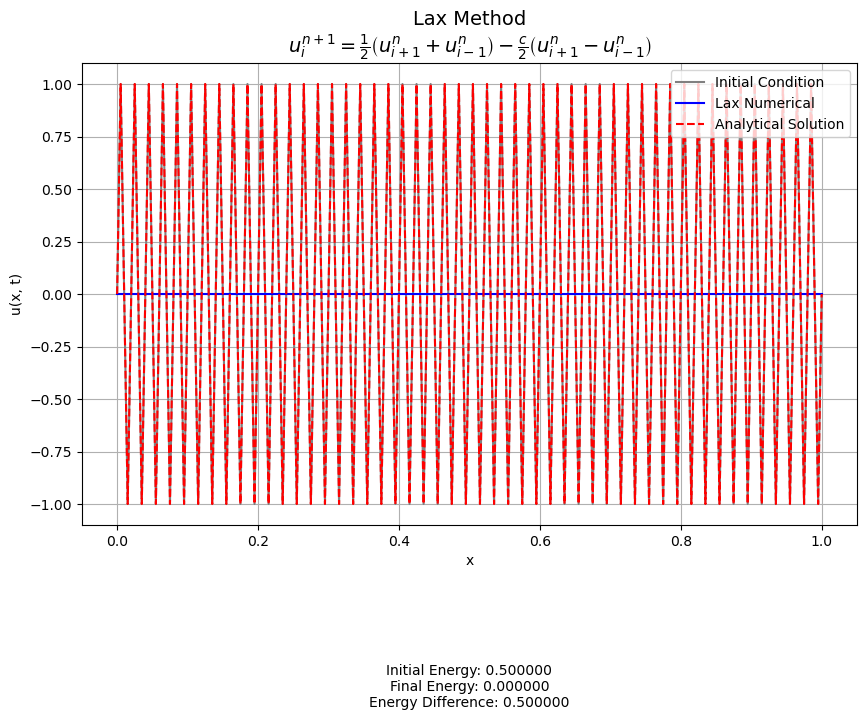

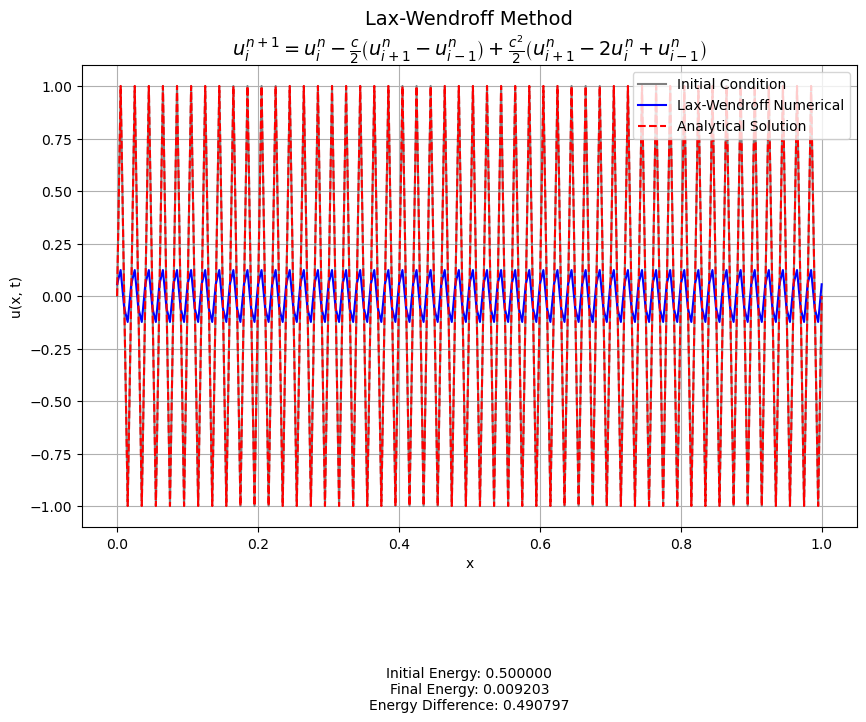

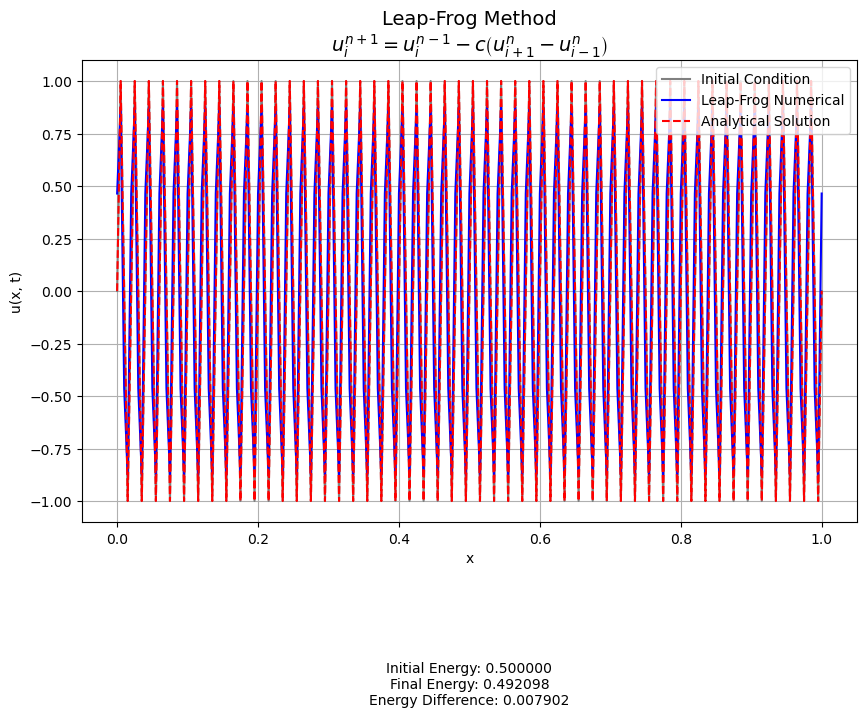

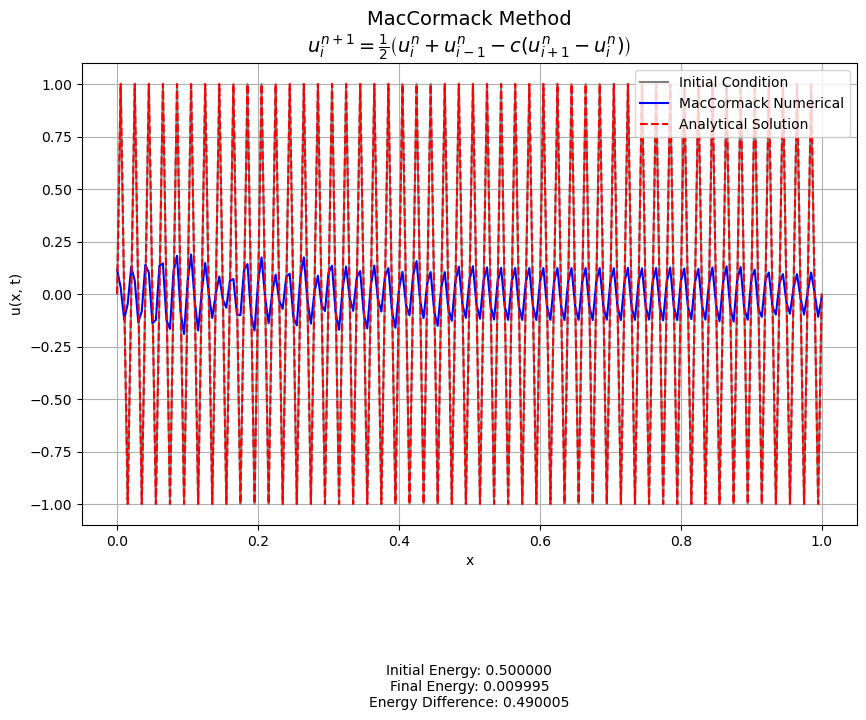

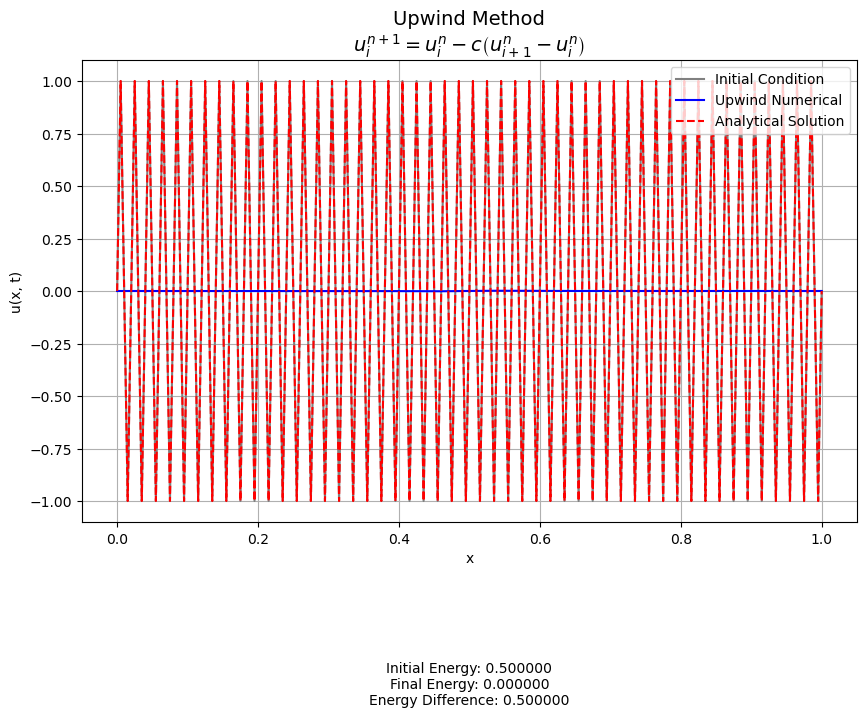

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve


a = 0.2  
L = 1.0 
T = 2.5  
N = 201  
dx = L / (N - 1)  
dt = 0.001  
Nt = int(T / dt) 
c = a * dt / dx 

if c > 1:
    raise ValueError("شرط CFL برقرار نیست: مقدار c باید <= 1 باشد.")



def lax_wendroff(u, c, N, Nt):
    for n in range(Nt):
        for i in range(1, N - 1):
            u[i, n + 1] = (
                u[i, n]
                - 0.5 * c * (u[i + 1, n] - u[i - 1, n])
                + 0.5 * c**2 * (u[i + 1, n] - 2 * u[i, n] + u[i - 1, n])
            )
        u[0, n + 1] = (
            u[0, n]
            - 0.5 * c * (u[1, n] - u[-2, n])
            + 0.5 * c**2 * (u[1, n] - 2 * u[0, n] + u[-2, n])
        )
        u[-1, n + 1] = u[0, n + 1]
    return u


def leap_frog(u, c, N, Nt):
    for i in range(1, N - 1):
        u[i, 1] = u[i, 0] - c * (u[i, 0] - u[i - 1, 0])
    u[0, 1] = u[0, 0] - c * (u[0, 0] - u[-2, 0])
    u[-1, 1] = u[0, 1]

    for n in range(1, Nt):
        for i in range(1, N - 1):
            u[i, n + 1] = u[i, n - 1] - c * (u[i + 1, n] - u[i - 1, n])
        u[0, n + 1] = u[0, n - 1] - c * (u[1, n] - u[-2, n])
        u[-1, n + 1] = u[0, n + 1]
    return u


def mac_cormack(u, c, N, Nt):
    for n in range(Nt):
        u_pred = np.zeros_like(u[:, n])
        u_pred[:-1] = u[:-1, n] - c * (u[1:, n] - u[:-1, n])
        u_pred[-1] = u[-1, n] - c * (u[0, n] - u[-1, n])
        u[1:, n + 1] = 0.5 * (u[1:, n] + u_pred[1:] - c * (u_pred[1:] - u_pred[:-1]))
        u[0, n + 1] = 0.5 * (u[0, n] + u_pred[0] - c * (u_pred[0] - u_pred[-1]))
    return u


def lax(u, c, N, Nt):
    for n in range(Nt):
        u[1:-1, n + 1] = 0.5 * (u[2:, n] + u[:-2, n]) - 0.5 * c * (u[2:, n] - u[:-2, n])
        u[0, n + 1] = 0.5 * (u[1, n] + u[-2, n]) - 0.5 * c * (u[1, n] - u[-2, n])
        u[-1, n + 1] = u[0, n + 1]
    return u



def upwind(u, c, N, Nt):
    A = np.eye(N)
    for i in range(1, N):
        A[i, i] = 1 - c
        A[i, i - 1] = c
    A[0, -1] = c
    A[0, 0] = 1 - c

    for n in range(Nt):
        u[:, n + 1] = A @ u[:, n]
    return u


def analytical_solution(x, a, t):
   
    return np.sin(100 * np.pi * (x - a * t))


def compute_energy(u, dx):
    
    return np.sum(u**2) * dx


methods = input(
    "روش های مورد نظر را انتخاب کنید (lax, lax_wendroff, leap_frog, mac_cormack, upwind یا all): "
).strip().split(",")

x = np.linspace(0, L, N)
results = {}


latex_formulas = {
    "Lax": r"$u_i^{n+1} = \frac{1}{2} \left( u_{i+1}^n + u_{i-1}^n \right) - \frac{c}{2} \left( u_{i+1}^n - u_{i-1}^n \right)$",
    "Lax-Wendroff": r"$u_i^{n+1} = u_i^n - \frac{c}{2} \left( u_{i+1}^n - u_{i-1}^n \right) + \frac{c^2}{2} \left( u_{i+1}^n - 2u_i^n + u_{i-1}^n \right)$",
    "Leap-Frog": r"$u_i^{n+1} = u_i^{n-1} - c \left( u_{i+1}^n - u_{i-1}^n \right)$",
    "MacCormack": r"$u_i^{n+1} = \frac{1}{2} \left( u_i^n + u_{i-1}^n - c (u_{i+1}^n - u_i^n) \right)$",
    "Upwind": r"$u_i^{n+1} = u_i^n - c \left( u_{i+1}^n - u_i^n \right)$",
}



for method in (methods if "all" not in methods else ["lax", "lax_wendroff", "leap_frog", "mac_cormack", "upwind"]):
    u = np.zeros((N, Nt + 1))
 
    u[:, 0] = np.sin(100 * np.pi * x)

    u_copy = u.copy()
    if method.strip() == "lax":
        results["Lax"] = lax(u_copy, c, N, Nt)
    elif method.strip() == "lax_wendroff":
        results["Lax-Wendroff"] = lax_wendroff(u_copy, c, N, Nt)
    elif method.strip() == "leap_frog":
        results["Leap-Frog"] = leap_frog(u_copy, c, N, Nt)
    elif method.strip() == "mac_cormack":
        results["MacCormack"] = mac_cormack(u_copy, c, N, Nt)
    elif method.strip() == "upwind":
        results["Upwind"] = upwind(u_copy, c, N, Nt)
    else:
        raise ValueError(f"روش '{method}' معتبر نیست.")
        
        


for method, u in results.items():
    initial_energy = compute_energy(u[:, 0], dx)
    final_energy = compute_energy(u[:, -1], dx)

    plt.figure(figsize=(10, 6))
    plt.plot(x, u[:, 0], label="Initial Condition", color='gray')
    plt.plot(x, u[:, -1], label=f"{method} Numerical", color='blue')

    analytical = analytical_solution(x, a, T)
    plt.plot(x, analytical, '--', label="Analytical Solution", color='red')

    text = (f"Initial Energy: {initial_energy:.6f}\n"
        f"Final Energy: {final_energy:.6f}\n"
        f"Energy Difference: {abs(initial_energy - final_energy):.6f}"
    )
    plt.text(0.5, -0.3, text, fontsize=10, transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='center')
   
    plt.title(f"{method} Method\n{latex_formulas[method]}", fontsize=14)
    plt.xlabel("x")
    plt.ylabel("u(x, t)")
    plt.legend()
    plt.grid()
    plt.show()


روش‌های مورد نظر را انتخاب کنید (lax, lax_wendroff, leap_frog, mac_cormack,  upwind یا all): all


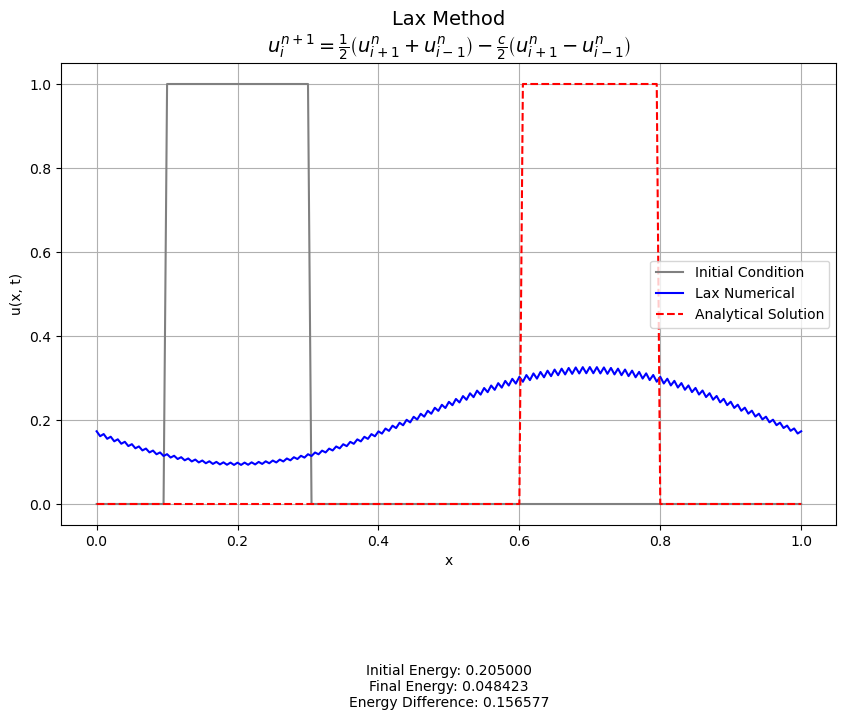

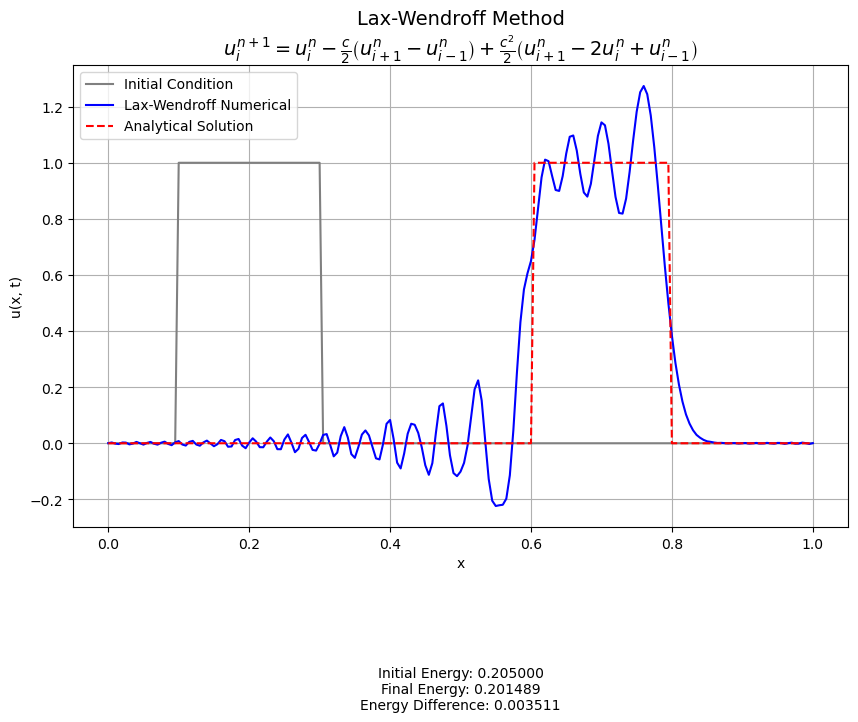

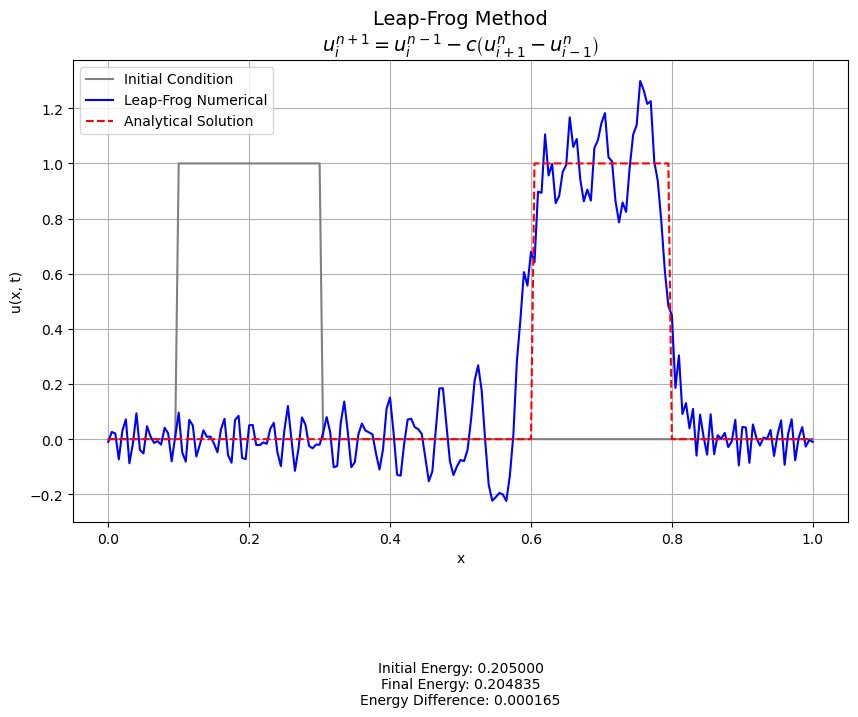

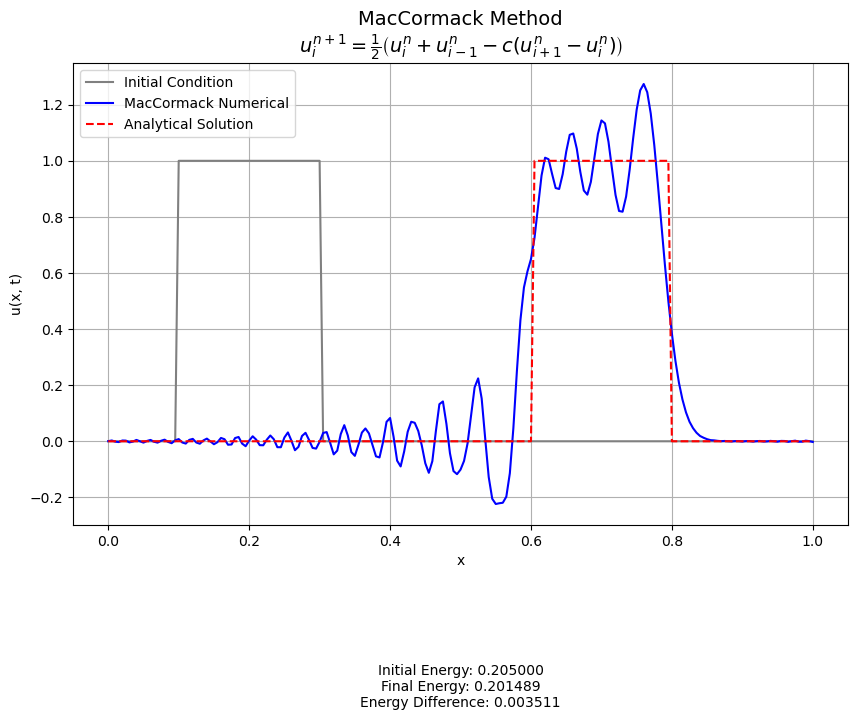

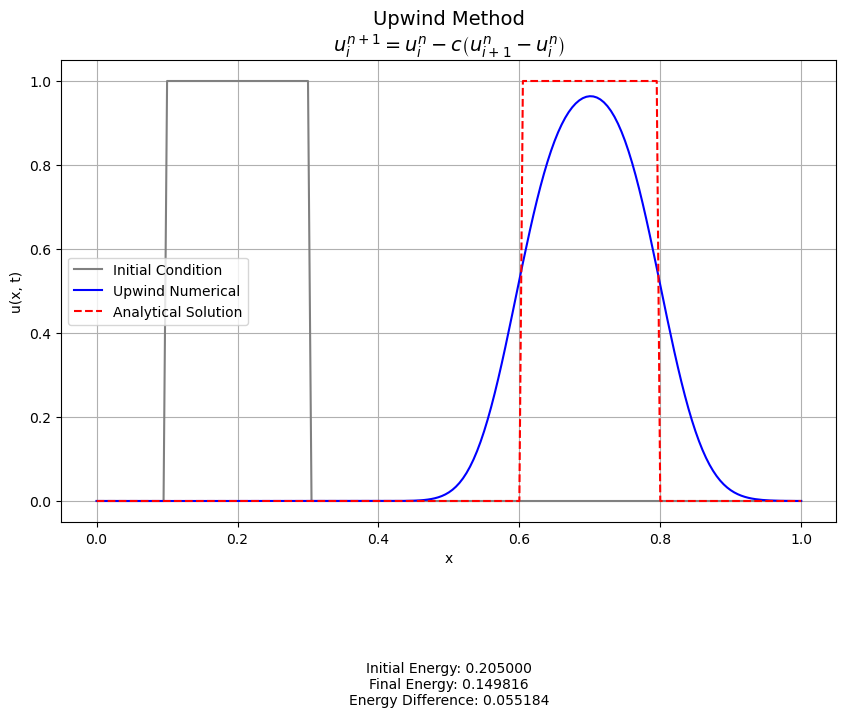

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve



a = 0.2  
L = 1.0  
T = 2.5  
N = 201  
dx = L / (N - 1)  
dt = 0.001  
Nt = int(T / dt) 
c = a * dt / dx  

if c > 1:
    raise ValueError("شرط CFL برقرار نیست: مقدار c باید <= 1 باشد.")

    
def lax_wendroff(u, c, N, Nt):
    for n in range(Nt):
        for i in range(1, N - 1):
            u[i, n + 1] = (
                u[i, n]
                - 0.5 * c * (u[i + 1, n] - u[i - 1, n])
                + 0.5 * c**2 * (u[i + 1, n] - 2 * u[i, n] + u[i - 1, n])
            )
        u[0, n + 1] = (
            u[0, n]
            - 0.5 * c * (u[1, n] - u[-2, n])
            + 0.5 * c**2 * (u[1, n] - 2 * u[0, n] + u[-2, n])
        )
        u[-1, n + 1] = u[0, n + 1]
    return u


def leap_frog(u, c, N, Nt):
    for i in range(1, N - 1):
        u[i, 1] = u[i, 0] - c * (u[i, 0] - u[i - 1, 0])
    u[0, 1] = u[0, 0] - c * (u[0, 0] - u[-2, 0])
    u[-1, 1] = u[0, 1]

    for n in range(1, Nt):
        for i in range(1, N - 1):
            u[i, n + 1] = u[i, n - 1] - c * (u[i + 1, n] - u[i - 1, n])
        u[0, n + 1] = u[0, n - 1] - c * (u[1, n] - u[-2, n])
        u[-1, n + 1] = u[0, n + 1]
    return u


def mac_cormack(u, c, N, Nt):
    for n in range(Nt):
        u_pred = np.zeros_like(u[:, n])
        u_pred[:-1] = u[:-1, n] - c * (u[1:, n] - u[:-1, n])
        u_pred[-1] = u[-1, n] - c * (u[0, n] - u[-1, n])
        u[1:, n + 1] = 0.5 * (u[1:, n] + u_pred[1:] - c * (u_pred[1:] - u_pred[:-1]))
        u[0, n + 1] = 0.5 * (u[0, n] + u_pred[0] - c * (u_pred[0] - u_pred[-1]))
    return u


def lax(u, c, N, Nt):
    for n in range(Nt):
        u[1:-1, n + 1] = 0.5 * (u[2:, n] + u[:-2, n]) - 0.5 * c * (u[2:, n] - u[:-2, n])
        u[0, n + 1] = 0.5 * (u[1, n] + u[-2, n]) - 0.5 * c * (u[1, n] - u[-2, n])
        u[-1, n + 1] = u[0, n + 1]
    return u



def upwind(u, c, N, Nt):
    A = np.eye(N)
    for i in range(1, N):
        A[i, i] = 1 - c
        A[i, i - 1] = c
    A[0, -1] = c
    A[0, 0] = 1 - c

    for n in range(Nt):
        u[:, n + 1] = A @ u[:, n]
    return u



def analytical_solution(x, a, t):

    x_shifted = (x - a * t) % L
    return np.where((x_shifted >= 0.1) & (x_shifted <= 0.3), 1, 0)


def compute_energy(u, dx):
 
    return np.sum(u**2) * dx



methods = input(
    "روش‌های مورد نظر را انتخاب کنید (lax, lax_wendroff, leap_frog, mac_cormack,  upwind یا all): "
).strip().split(",")

x = np.linspace(0, L, N)
results = {}



latex_formulas = {
    "Lax": r"$u_i^{n+1} = \frac{1}{2} \left( u_{i+1}^n + u_{i-1}^n \right) - \frac{c}{2} \left( u_{i+1}^n - u_{i-1}^n \right)$",
    "Lax-Wendroff": r"$u_i^{n+1} = u_i^n - \frac{c}{2} \left( u_{i+1}^n - u_{i-1}^n \right) + \frac{c^2}{2} \left( u_{i+1}^n - 2u_i^n + u_{i-1}^n \right)$",
    "Leap-Frog": r"$u_i^{n+1} = u_i^{n-1} - c \left( u_{i+1}^n - u_{i-1}^n \right)$",
    "MacCormack": r"$u_i^{n+1} = \frac{1}{2} \left( u_i^n + u_{i-1}^n - c (u_{i+1}^n - u_i^n) \right)$",
    "Upwind": r"$u_i^{n+1} = u_i^n - c \left( u_{i+1}^n - u_i^n \right)$",
}


for method in (methods if "all" not in methods else ["lax", "lax_wendroff", "leap_frog", "mac_cormack", "upwind"]):
    u = np.zeros((N, Nt + 1))
    u[:, 0] = np.where((x >= 0.1) & (x <= 0.3), 1, 0)

    u_copy = u.copy()
    if method.strip() == "lax":
        results["Lax"] = lax(u_copy, c, N, Nt)
    elif method.strip() == "lax_wendroff":
        results["Lax-Wendroff"] = lax_wendroff(u_copy, c, N, Nt)
    elif method.strip() == "leap_frog":
        results["Leap-Frog"] = leap_frog(u_copy, c, N, Nt)
    elif method.strip() == "mac_cormack":
        results["MacCormack"] = mac_cormack(u_copy, c, N, Nt)
    elif method.strip() == "upwind":
        results["Upwind"] = upwind(u_copy, c, N, Nt)
    else:
        raise ValueError(f"روش '{method}' معتبر نیست.")


for method, u in results.items():
    initial_energy = compute_energy(u[:, 0], dx)
    final_energy = compute_energy(u[:, -1], dx)

    plt.figure(figsize=(10, 6))
    plt.plot(x, u[:, 0], label="Initial Condition", color='gray')
    plt.plot(x, u[:, -1], label=f"{method} Numerical", color='blue')

    analytical = analytical_solution(x, a, T)
    plt.plot(x, analytical, '--', label="Analytical Solution", color='red')

    text = (f"Initial Energy: {initial_energy:.6f}\n"
        f"Final Energy: {final_energy:.6f}\n"
        f"Energy Difference: {abs(initial_energy - final_energy):.6f}"
    )
    plt.text(0.5, -0.3, text, fontsize=10, transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='center')

    plt.title(f"{method} Method\n{latex_formulas[method]}", fontsize=14)
    plt.xlabel("x")
    plt.ylabel("u(x, t)")
    plt.legend()
    plt.grid()
    plt.show()
